### Imports and Setup

In [1]:
import warnings

import networkx as nx
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import sqrtm
from scipy import sparse
from sklearn.metrics import f1_score, average_precision_score

from mvgl.data import gen_consensus_graph
from mvgl.graphlearning.utils import rowsum_mat

rng = np.random.default_rng(seed=1)

sns.set_theme("paper", "whitegrid")

%config InlineBackend.figure_format='retina'

### Functions

In [5]:
def _sigma_mat(covariance_mat):
    n_nodes = covariance_mat.shape[0] # number of nodes
    identity_mat = sparse.eye(n_nodes)

    return (sparse.kron(-covariance_mat, identity_mat) 
            + sparse.kron(identity_mat, covariance_mat))

def _upper_to_all_mat(n):
    i, j = np.triu_indices(n, k=1)
    M = len(i)
    rows = np.concatenate((i*n+j, j*n+i))
    cols = np.concatenate((np.arange(M), np.arange(M)))

    return sparse.csr_matrix((np.ones((2*M, )), (rows, cols)), shape=(n**2, M))

def _diag_to_all_mat(n):
    i, j = np.diag_indices(n)
    rows = i*n + j
    cols = np.arange(n)

    return sparse.csr_matrix((np.ones((n, )), (rows, cols)), shape=(n**2, n))

### Generate the graph

In [60]:
n_nodes = 20
n_pairs = n_nodes*(n_nodes-1)//2

graph = gen_consensus_graph(n_nodes, "er", p = 0.2, rng=rng)
S0 = nx.adjacency_matrix(graph).toarray()
L0 = nx.laplacian_matrix(graph).toarray()

v_s0 = S0[np.triu_indices_from(S0, k=1)]
v_l0 = L0[np.triu_indices_from(L0, k=1)]

### Learning the Adjacency Matrix

#### Stationary Graph Signal Generation from Adjacency Matrix

Questions:
- Do I need to normalize graph shift operator before generating the signals?

In [69]:
filter_degree = 5
n_signals = -1 # non-positive value means we observe true covariance matrix

# Construct the graph filter
filter_coeffs = rng.normal(0, 1, size=filter_degree)
filter_mat = np.zeros(shape=(n_nodes, n_nodes))

for i in range(filter_degree):
    filter_mat += filter_coeffs[i]*np.linalg.matrix_power(S0, i)

# Generate the graph signals
cov_mat = filter_mat@filter_mat 
cov_mat = (cov_mat + cov_mat.T)/2

if n_signals > 0:
    white_noise = rng.normal(0, 1, size=(n_nodes, n_signals))
    graph_signals = sqrtm(cov_mat)@white_noise
    cov_mat = (graph_signals@graph_signals.T)/n_signals

cov_mat = cov_mat/np.linalg.norm(cov_mat, "fro")

#### Learn the Adjacency Matrix

The following cell learns the adjacency matrix by solving the below optimization
problem:
$$
\begin{align*}
\mathrm{minimize}_{\mathbf{S} \in \mathbb{R}^{n \times n}} &\ ||\mathbf{S}||_1 \\
\mathrm{such\ that} \quad \quad \ &\  
    \mathbf{S} = \mathbf{S}^\top,\ 
    \mathbf{S}\mathbf{1} \geq \mathbf{1},\ 
    \mathrm{diag}(\mathbf{S}) = \mathbf{0},\ 
    ||\mathbf{C}\mathbf{S} - \mathbf{S}\mathbf{C}||_F \leq \epsilon
\end{align*}
$$

In [7]:
S = cp.Variable(shape=(n_nodes, n_nodes), symmetric=True)
alpha = cp.Parameter(nonneg=True)

objective = cp.Minimize(cp.pnorm(S, p=1))
constraints = [
    cp.diag(S) <= 1e-4, 
    cp.sum(S, axis=1) >= 1, 
    cp.norm(cov_mat@S - S@cov_mat, "fro") <= alpha,
    S >= 0,
]
problem = cp.Problem(objective, constraints)

alpha_vals = np.logspace(-8, -3, 20, endpoint=True)
best_auprc = -1
for a in alpha_vals:
    alpha.value = a
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            out = problem.solve(warm_start=True)
            solver_failed = False
        except:
            solver_failed = True

    S_hat = S.value
    if (not solver_failed) and (S_hat is not None):
        v_s_hat_curr = S_hat[np.triu_indices_from(S_hat, k=1)]
        v_s_hat_curr[v_s_hat_curr < 0] = 0

        auprc = average_precision_score(v_s0, v_s_hat_curr)
        if auprc > best_auprc:
            v_s_hat = v_s_hat_curr
            best_auprc = auprc

print(f"AUPRC: {average_precision_score(v_s0, v_s_hat):.2f}")

AUPRC: 0.34


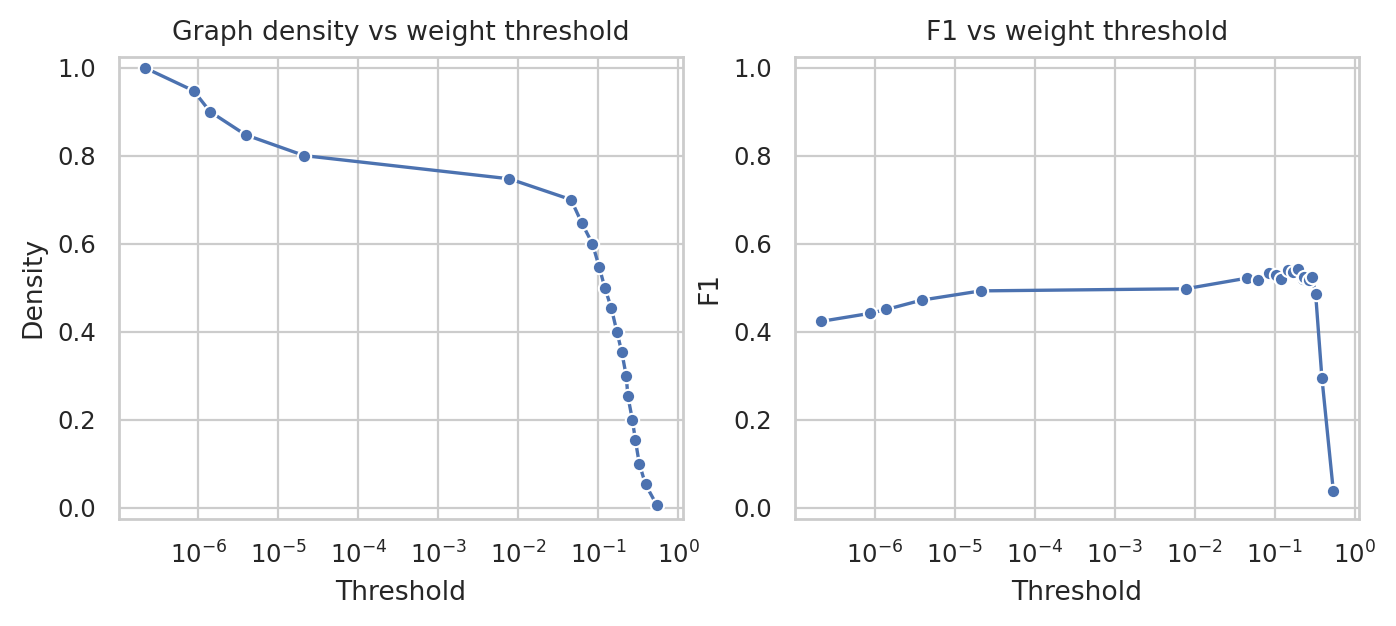

In [198]:
quantiles = np.linspace(0, 1.0, 21, endpoint=True)
thresholds = np.unique(np.quantile(v_s_hat, quantiles))

densities = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
for i, th in enumerate(thresholds):
    v_s_hat_th = v_s_hat.copy()
    v_s_hat_th[v_s_hat_th < th] = 0
    v_s_hat_th[v_s_hat_th > 0] = 1
    f1s[i] = f1_score(v_s0, v_s_hat_th)
    densities[i] = np.count_nonzero(v_s_hat_th)/len(v_s_hat_th)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

ax = axs[0]
sns.lineplot(x=thresholds, y=densities, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("Graph density vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Density")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax = axs[1]
sns.lineplot(x=thresholds, y=f1s, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("F1 vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

The following cell solves a modification of above problem where $\ell_1$-norm 
is removed:
$$
\begin{align*}
\mathrm{minimize}_{\mathbf{S} \in \mathbb{R}^{n \times n}} &\ 0 \\
\mathrm{such\ that} \quad \quad \ &\  
    \mathbf{S} = \mathbf{S}^\top,\ 
    \mathbf{S}\mathbf{1} \geq \mathbf{1},\ 
    \mathrm{diag}(\mathbf{S}) = \mathbf{0},\ 
    ||\mathbf{C}\mathbf{S} - \mathbf{S}\mathbf{C}||_F \leq \epsilon
\end{align*}
$$
This allow us to see effect of $\ell_1$-norm on learning the adjacency matrix.

In [199]:
S = cp.Variable(shape=(n_nodes, n_nodes), symmetric=True)
alpha = cp.Parameter(nonneg=True)

objective = cp.Minimize(0)
constraints = [
    cp.diag(S) <= 1e-4, 
    cp.sum(S, axis=1) >= 1, 
    cp.norm(cov_mat@S - S@cov_mat, "fro") <= alpha,
    S >= 0,
]
problem = cp.Problem(objective, constraints)

alpha_vals = np.logspace(-8, -3, 20, endpoint=True)
best_auprc = -1
for a in alpha_vals:
    alpha.value = a
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            out = problem.solve(warm_start=True)
            solver_failed = False
        except:
            solver_failed = True

    S_hat = S.value
    if (not solver_failed) and (S_hat is not None):
        v_s_hat_curr = S_hat[np.triu_indices_from(S_hat, k=1)]
        v_s_hat_curr[v_s_hat_curr < 0] = 0

        auprc = average_precision_score(v_s0, v_s_hat_curr)
        if auprc > best_auprc:
            v_s_hat = v_s_hat_curr
            best_auprc = auprc

print(f"AUPRC: {average_precision_score(v_s0, v_s_hat):.2f}")

AUPRC: 0.66


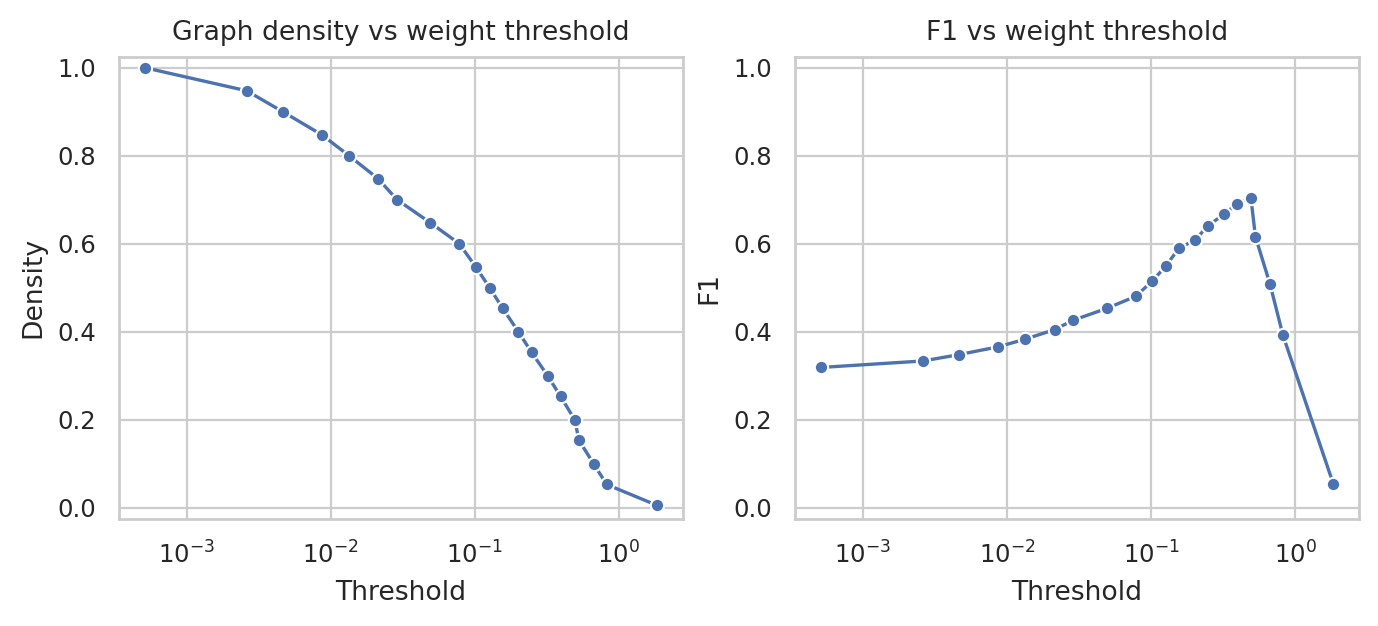

In [269]:
quantiles = np.linspace(0, 1, 21, endpoint=True)
thresholds = np.unique(np.quantile(v_s_hat, quantiles))

densities = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
for i, th in enumerate(thresholds):
    v_s_hat_th = v_s_hat.copy()
    v_s_hat_th[v_s_hat_th < th] = 0
    v_s_hat_th[v_s_hat_th > 0] = 1
    f1s[i] = f1_score(v_s0, v_s_hat_th)
    densities[i] = np.count_nonzero(v_s_hat_th)/len(v_s_hat_th)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

ax = axs[0]
sns.lineplot(x=thresholds, y=densities, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("Graph density vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Density")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

ax = axs[1]
sns.lineplot(x=thresholds, y=f1s, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("F1 vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

We futher modify our optimization problem as follows:
$$
\begin{align*}
\mathrm{minimize}_{\mathbf{S} \in \mathbb{R}^{n \times n}} &\ 
    ||\mathbf{C}\mathbf{S} - \mathbf{S}\mathbf{C}||_F \\
\mathrm{such\ that} \quad \quad \ &\  
    \mathbf{S} = \mathbf{S}^\top,\ 
    \mathbf{S}\mathbf{1} \geq \mathbf{1},\ 
    \mathrm{diag}(\mathbf{S}) = \mathbf{0},\
\end{align*}
$$
This allow us to get rid of hyperparameter $\epsilon$.

In [270]:
S = cp.Variable(shape=(n_nodes, n_nodes), symmetric=True)

objective = cp.Minimize(cp.pnorm(cov_mat@S - S@cov_mat, p=2))
constraints = [
    cp.diag(S) <= 1e-4, 
    cp.sum(S, axis=1) >= 1,
    S >= 0,
]
problem = cp.Problem(objective, constraints)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    try:
        out = problem.solve(warm_start=True)
    except:
        pass

S_hat = S.value

if S_hat is not None:
    # Performance metrics
    v_s0 = S0[np.triu_indices_from(S0, k=1)]
    v_s_hat = S_hat[np.triu_indices_from(S_hat, k=1)]
    v_s_hat[v_s_hat < 0] = 0

    print(f"AUPRC: {average_precision_score(v_s0, v_s_hat):.4f}")

AUPRC: 0.8377


In [ ]:
quantiles = np.linspace(0, 1, 21, endpoint=True)
thresholds = np.unique(np.quantile(v_s_hat, quantiles))

densities = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
for i, th in enumerate(thresholds):
    v_s_hat_th = v_s_hat.copy()
    v_s_hat_th[v_s_hat_th < th] = 0
    v_s_hat_th[v_s_hat_th > 0] = 1
    f1s[i] = f1_score(v_s0, v_s_hat_th)
    densities[i] = np.count_nonzero(v_s_hat_th)/len(v_s_hat_th)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

ax = axs[0]
sns.lineplot(x=thresholds, y=densities, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("Graph density vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Density")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

ax = axs[1]
sns.lineplot(x=thresholds, y=f1s, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("F1 vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

#### Learn the Adjacency Matrix - Vectorized

We will solve above optimization problems in vectorized form where we learn
the upper triangular part of adjacency matrix. Define the following variables:
- $\mathbf{s} \in \mathbb{R}^{n(n-1)/2}$: upper triangular part of $\mathbf{S}$,
- $\mathbf{s}_a \in \mathbb{R}^{n^2}$: column-wise vectorization of $\mathbf{S}$,
- Define operator $\mathbf{Q} \in \mathbb{R}^{n \times n}$ s.t. $\mathbf{s}_a =
  \mathbf{Q}\mathbf{s}$.
- Define $\mathbf{\Sigma} = -\mathbf{C} \oplus \mathbf{C}$.

Then we have the following:
$$
||\mathbf{C}\mathbf{S} - \mathbf{S}\mathbf{C}||_F = ||\mathbf{\Sigma}\mathbf{Q}\mathbf{s}||_2
$$

In [70]:
m_Sigma = _sigma_mat(cov_mat)
m_Q = _upper_to_all_mat(n_nodes)
m_S = rowsum_mat(n_nodes)

print(np.linalg.norm(cov_mat@S0 - S0@cov_mat, "fro"))
print(np.linalg.norm(m_Sigma@m_Q@v_s0))

7.290628165848072e-16
6.304595266619409e-16


In [76]:
n_pairs = int(n_nodes*(n_nodes-1)/2)

s = cp.Variable(shape=(n_pairs, 1))

objective = cp.Minimize(cp.pnorm(m_Sigma@m_Q@s))
constraints = [
    cp.sum(s) >= n_nodes,
    s >= 0,
]
problem = cp.Problem(objective, constraints)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
out = problem.solve(max_iter=10000)

v_s_hat = s.value

# Performance metrics
v_s0 = S0[np.triu_indices_from(S0, k=1)]
# v_s_hat[v_s_hat < 0] = 0

print(f"AUPRC: {average_precision_score(v_s0, v_s_hat):.4f}")

AUPRC: 1.0000


In [77]:
np.sum(v_s_hat)

20.06037595784552

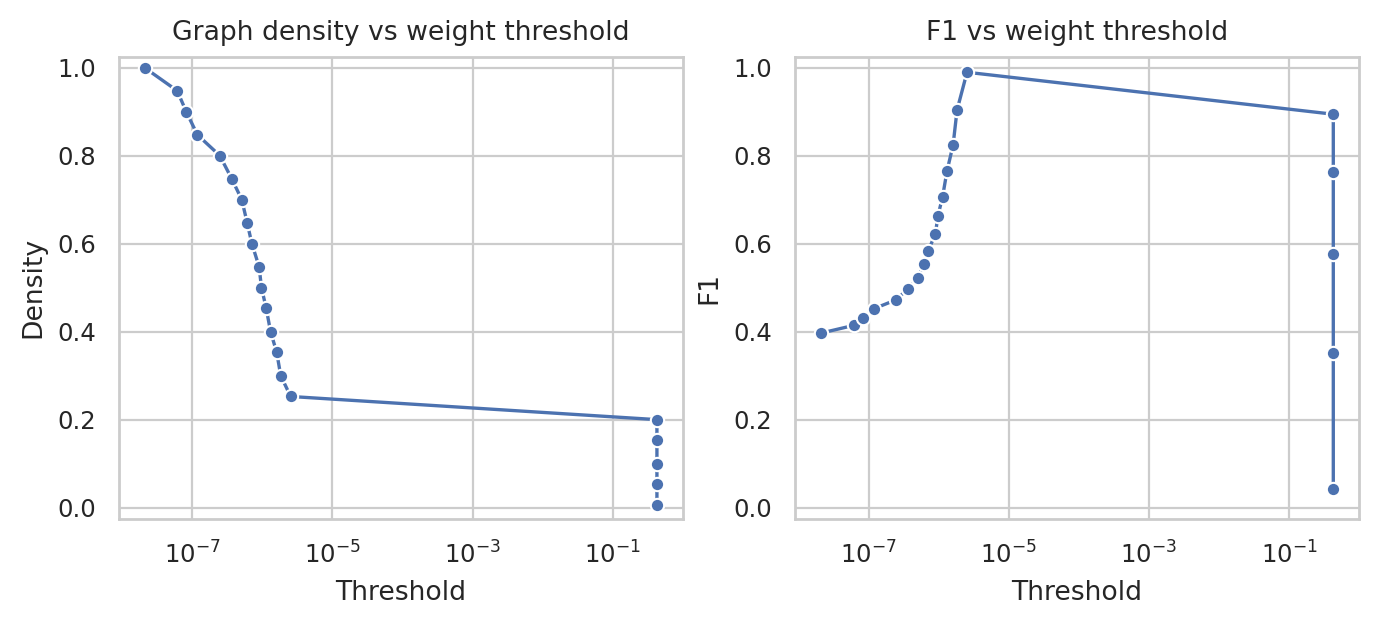

In [78]:
quantiles = np.linspace(0, 1, 21, endpoint=True)
thresholds = np.unique(np.quantile(v_s_hat, quantiles))

densities = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
for i, th in enumerate(thresholds):
    v_s_hat_th = v_s_hat.copy()
    v_s_hat_th[v_s_hat_th < th] = 0
    v_s_hat_th[v_s_hat_th > 0] = 1
    f1s[i] = f1_score(v_s0, v_s_hat_th)
    densities[i] = np.count_nonzero(v_s_hat_th)/len(v_s_hat_th)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

ax = axs[0]
sns.lineplot(x=thresholds, y=densities, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("Graph density vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Density")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

ax = axs[1]
sns.lineplot(x=thresholds, y=f1s, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("F1 vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

In [83]:
param_k = int(n_pairs*0.25)
param_rho = 1

# Initialization
v_z = v_s_hat.copy()
kth_largest = v_z[np.argpartition(v_z, -param_k, axis=0)[-param_k, 0]]
v_z[v_z < kth_largest] = 0
# v_z = np.zeros((n_pairs, 1))
v_y = np.zeros((n_pairs, 1))

print(f"AUPRC(s): {average_precision_score(v_s0, v_z):.4f}")

cp_s = cp.Variable(shape=(n_pairs, 1))
cp_z = cp.Parameter(shape=(n_pairs, 1))
cp_y = cp.Parameter(shape=(n_pairs, 1))

objective = cp.Minimize(
    cp.pnorm(m_Sigma@m_Q@cp_s, p=2) + 
    0.5*param_rho*cp.pnorm(cp_s - cp_z + cp_y/param_rho, p=2)**2
)
constraints = [cp.sum(cp_s) >= n_nodes]
problem = cp.Problem(objective)

for i in range(500):
    cp_z.value = v_z
    cp_y.value = v_y
    problem.solve(warm_start=True)

    v_s = cp_s.value

    v_z = v_s + v_y/param_rho
    kth_largest = v_z[np.argpartition(v_z, -param_k, axis=0)[-param_k, 0]]
    v_z[v_z < kth_largest] = 0

    v_y += param_rho*(v_s - v_z)

    if (i) % 20 == 0:
        print(f"{np.linalg.norm(v_s - v_z):.8f}", end=" ")
        print(f"AUPRC(s): {average_precision_score(v_s0, v_s):.4f}", end=" ")
        print(f"F1(s): {f1_score(v_s0, (v_z > 0).astype(int)):.4f}")

AUPRC(s): 1.0000
0.00000219 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(s): 1.0000 F1(s): 1.0000
0.00000000 AUPRC(

### Learning the Laplacian Matrix

In [ ]:
filter_degree = 5
n_signals = -1 # non-positive value means we observe true covariance matrix

# Construct the graph filter
filter_coeffs = rng.normal(0, 1, size=filter_degree)
filter_mat = np.zeros(shape=(n_nodes, n_nodes))

for i in range(filter_degree):
    filter_mat += filter_coeffs[i]*np.linalg.matrix_power(L0, i)

# Generate the graph signals
cov_mat = filter_mat@filter_mat 
cov_mat = (cov_mat + cov_mat.T)/2

if n_signals > 0:
    white_noise = rng.normal(0, 1, size=(n_nodes, n_signals))
    graph_signals = sqrtm(cov_mat)@white_noise
    cov_mat = (graph_signals@graph_signals.T)/n_signals

cov_mat = cov_mat/np.linalg.norm(cov_mat, "fro")

In [191]:
m_Sigma = _sigma_mat(cov_mat)
m_Q = _upper_to_all_mat(n_nodes)
m_R = _diag_to_all_mat(n_nodes)
m_S = rowsum_mat(n_nodes)

print(np.linalg.norm(cov_mat@L0 - L0@cov_mat, "fro"))
print(np.linalg.norm(m_Sigma@(m_Q - m_R@m_S)@v_s0))

2.077767948979728
2.077767948979728


In [192]:
L = cp.Variable((n_nodes, n_nodes), symmetric=True)

objective = cp.Minimize(cp.pnorm(cp.upper_tri(L), p=1) - cp.sum(cp.log(cp.diag(L))))
constraints = [
    cp.upper_tri(L) <= 0,
    cp.sum(L, 1) == 0,
    cp.norm(cov_mat@L - L@cov_mat, "fro") <= 1e-2
]
problem = cp.Problem(objective, constraints)

problem.solve(max_iter=1000)

L_hat = L.value

v_s_hat = np.abs(L_hat[np.triu_indices_from(L_hat, k=1)])

SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

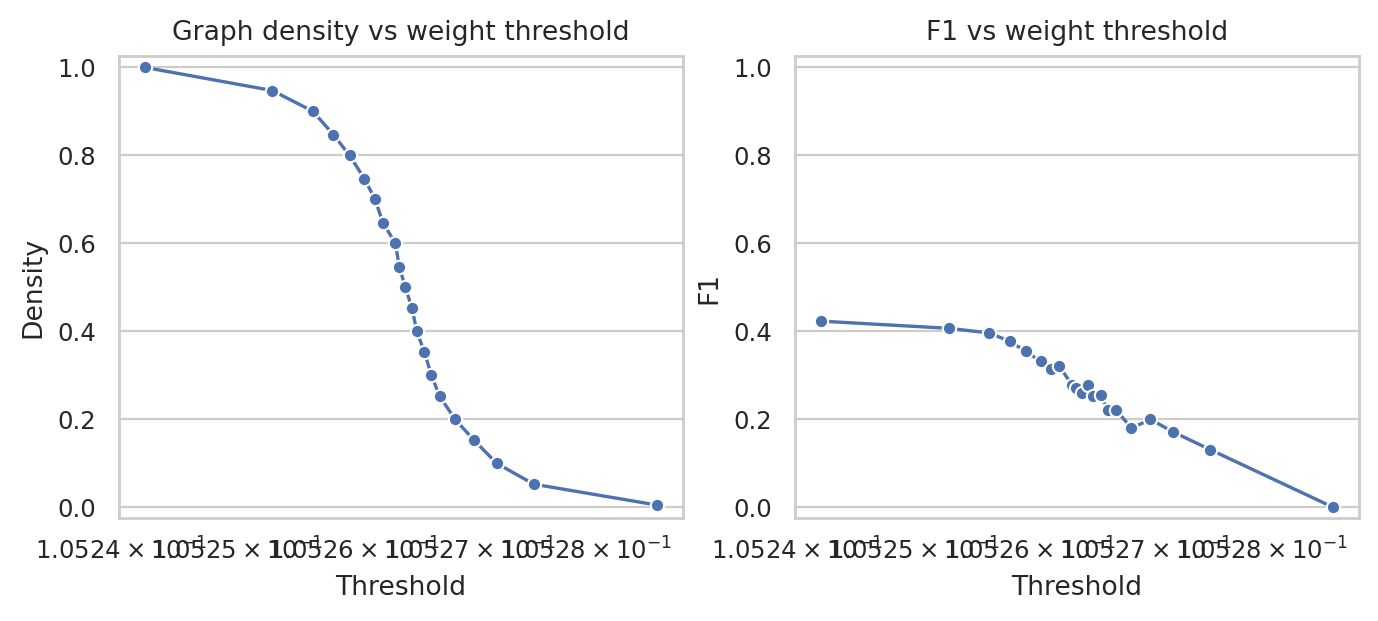

In [ ]:
quantiles = np.linspace(0, 1, 21, endpoint=True)
thresholds = np.unique(np.quantile(v_s_hat, quantiles))

densities = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
for i, th in enumerate(thresholds):
    v_s_hat_th = v_s_hat.copy()
    v_s_hat_th[v_s_hat_th < th] = 0
    v_s_hat_th[v_s_hat_th > 0] = 1
    f1s[i] = f1_score(v_s0, v_s_hat_th)
    densities[i] = np.count_nonzero(v_s_hat_th)/len(v_s_hat_th)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

ax = axs[0]
sns.lineplot(x=thresholds, y=densities, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("Graph density vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Density")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

ax = axs[1]
sns.lineplot(x=thresholds, y=f1s, ax=ax, marker="o")

ax.set_xscale("log")
ax.set_title("F1 vs weight threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")
ax.set_ylim([-0.025, 1.025])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

In [ ]:
m_D = _sigma_mat(cov_mat)
m_Q = _upper_to_all_mat(n_nodes)
m_R = _diag_to_all_mat(n_nodes)
m_S = rowsum_mat(n_nodes)

l = cp.Variable((n_pairs, 1))

objective = cp.Minimize(
    cp.sum_squares(m_D@(m_Q-m_R@m_S)@l) + 
    alpha*cp.norm(l, 1) 
)

constraints = [
    l <= 0,
    m_S@l <= -1,
]

problem = cp.Problem(objective, constraints)
problem.solve(max_iter=1000)

print(np.linalg.norm(m_D@(m_Q-m_R@m_S)@l.value))

NameError: name 'alpha' is not defined

In [ ]:
l.value

array([[-0.05270029],
       [-0.05265131],
       [-0.0526606 ],
       [-0.05264926],
       [-0.05261239],
       [-0.05255785],
       [-0.05265516],
       [-0.05267811],
       [-0.05268385],
       [-0.05262373],
       [-0.05266828],
       [-0.05256511],
       [-0.05263596],
       [-0.05262517],
       [-0.05254878],
       [-0.05262563],
       [-0.05260212],
       [-0.05267323],
       [-0.05258318],
       [-0.05277105],
       [-0.05257896],
       [-0.05257981],
       [-0.05260677],
       [-0.05257173],
       [-0.0525797 ],
       [-0.052625  ],
       [-0.05253614],
       [-0.05261877],
       [-0.05267146],
       [-0.05264593],
       [-0.05265927],
       [-0.05274024],
       [-0.05261147],
       [-0.05260695],
       [-0.0526539 ],
       [-0.05259701],
       [-0.05264554],
       [-0.05262313],
       [-0.05259268],
       [-0.05265911],
       [-0.0525476 ],
       [-0.05262339],
       [-0.05272097],
       [-0.052703  ],
       [-0.05265635],
       [-0

### Multiview Graph Learning

In [84]:
import mvgl

# Generate simulated data
Gc, Gv, Xv = mvgl.gen_simulated_data(
    n_nodes=100, n_views=3, n_signals=500, graph_generator="er", perturbation="0.1", 
    signal_type="stationary", noise=0.1, p=0.1, seed=1
)

TypeError: gen_simulated_data() got an unexpected keyword argument 'signal_type'